In [1]:
## Compare Kriging results to literature based on Webster and Oliver

In [2]:
# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [3]:
# Data and distances:
data = np.array([[0,0,7.0],
                [0,1,6.9],
                [0,2,7.9],
                [0,3,8.0],
                [1,0,6.0],
                [1,1,6.2],
                [1,2,8.0],
                [1,3,8.0],
                [2,0,5.8],
                [2,1,6.2],
                [2,2,7.8],
                [2,3,8.0],
                [3,0,6.0],
                [3,1,6.2],
                [3,2,7.8],
                [3,3,8.0]])

data[:,0] = data[:,0]*40
data[:,1] = data[:,1]*40

#print(data)

target = np.array([[1.5,1.5]])
target = target*40

dist_all_to_all = cdist(data[:, :2], data[:, :2])
dist_target_to_all = cdist(target, data[:, :2])


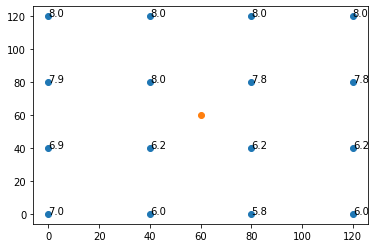

In [4]:
fig, ax = plt.subplots()
ax.scatter(data[:,0],data[:,1])
ax.scatter(target[:,0],target[:,1])

for i, txt in enumerate(data[:,2]):
    ax.annotate(txt, (data[:,0][i],data[:,1][i]))


In [7]:
d_plot = np.arange(0,400,1)

sill = 0.382
range_ = 90.53
nugget = 0.1
inp_mean = np.mean(data[:,2])
vario_plot1 = exponential_variogram_model(d_plot)

sill = 0.382
range_ = 90.53
nugget = 0
inp_mean = np.mean(data[:,2])
d_plot = np.arange(0,400,1)
vario_plot2 = exponential_variogram_model(d_plot)

sill = 0.382
range_ = 90.53
nugget = 0.3
inp_mean = np.mean(data[:,2])
vario_plot3 = exponential_variogram_model(d_plot)

0.382
0.28200000000000003
0.1
90.53
0.382
0.382
0
90.53
0.382
0.08200000000000002
0.3
90.53


(0, 0.4)

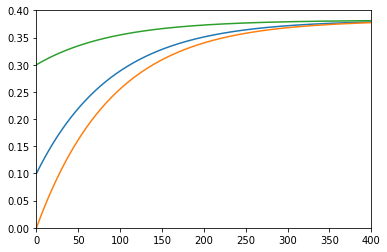

In [8]:
plt.plot(d_plot, vario_plot1)
plt.plot(d_plot, vario_plot2)
plt.plot(d_plot, vario_plot3)
plt.xlim(0,400)
plt.ylim(0,0.4)


In [9]:
sill = 0.382
range_ = 90.53
nugget = 0.1
inp_mean = np.mean(data[:,2])
print(inp_mean)

7.112500000000001


In [10]:
# FUCK YES I GOT IT!!!
#varince still slightly off

#test_res, test_var, w = simple_kriging(dist_target_to_all[0], dist_all_to_all, data[:,2])
#print(test_res)
#print(test_var)

test_res, test_var, w = ordinary_kriging(dist_target_to_all[0], dist_all_to_all, data[:,2])
print(test_res)
print(test_var)

0.382
0.28200000000000003
0.1
90.53
0.382
0.28200000000000003
0.1
90.53
7.055930873342108
0.18909912056831876


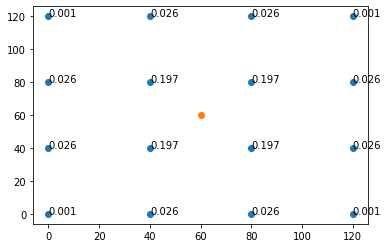

In [11]:
fig, ax = plt.subplots()
ax.scatter(data[:,0],data[:,1])
ax.scatter(target[:,0],target[:,1])

for i, txt in enumerate(np.round(w[:-1],3)):
    ax.annotate(txt, (data[:,0][i],data[:,1][i]))

In [12]:
def exponential_covariance_model(d):
    psill = sill #- nugget
    cov = psill * (np.exp(-(np.absolute(d) / (range_))))
    return cov   
    
def simple_kriging(a, b, prop):
      
    # empty matrix building
    shape = len(a)
    C = np.zeros((shape, shape))
    c = np.zeros((shape))
    w = np.zeros((shape))

    # Filling matrices with covariances based on calculated distances
    C[:shape, :shape] = exponential_covariance_model(b)
    c[:shape] = exponential_covariance_model(a)
    
    # Solve Kriging equations
    w = np.linalg.solve(C,c)
    
    #Kriging the mean:
    C_km = np.zeros((shape+1, shape+1))
    C_km[:shape, :shape] = C
    c_km = np.zeros(shape+1)
    C_km[shape, :] = 1.0
    C_km[:, shape] = 1.0
    C_km[shape, shape] = 0.0
    c_km[shape] = 1.0
    w_km = np.linalg.solve(C_km, c_km)
    
    used_mean = np.dot(w_km[:shape], prop)
    
    # calculating estimate and variance for kriging
    pred_var = sill - np.sum(w * c)
    result = used_mean + np.sum(w * (prop - used_mean))

    return result, pred_var, w

def exponential_variogram_model(d):
    psill = sill- nugget # depending on input
    
    print(sill)
    print(psill)
    print(nugget)
    print(range_)
    
    gamma = psill * (1. - np.exp(-d / (range_))) + nugget
    return gamma

def ordinary_kriging(a, b, prop):

    shape = len(a)
    C = np.zeros((shape + 1, shape + 1))
    c = np.zeros((shape + 1))
    w = np.zeros((shape + 1))

    
    # filling matirces based on model for spatial correlation
    C[:shape, :shape] = exponential_variogram_model(b)
    c[:shape] = exponential_variogram_model(a)
    
    np.fill_diagonal(C,0)
    
    # matrix setup - compare pykrige, special for OK
    C[shape, :] = 1.0
    C[:, shape] = 1.0
    C[shape, shape] = 0.0
    c[shape] = 1.0

    # TODO: find way to check quality of matrix and solutions for instability
    # Solve Kriging equations
    w = np.linalg.solve(C, c)
    
    # calculating estimate and variance for kriging, variance is weird
    pred_var = w[shape] + np.sum(w[:shape] * c[:shape])
    #result = np.sum(w[:shape] * prop)

    result = np.dot(prop, w[:shape])
    
    return result, pred_var,w

In [13]:
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

In [14]:
import numpy as np
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

data = np.array([[0,0,7.0],
                [0,1,6.9],
                [0,2,7.9],
                [0,3,8.0],
                [1,0,6.0],
                [1,1,6.2],
                [1,2,8.0],
                [1,3,8.0],
                [2,0,5.8],
                [2,1,6.2],
                [2,2,7.8],
                [2,3,8.0],
                [3,0,6.0],
                [3,1,6.2],
                [3,2,7.8],
                [3,3,8.0]])

data[:,0] = data[:,0]*40
data[:,1] = data[:,1]*40


par = list((0.382, range_*3, 0.3))

# Create the ordinary kriging object. Required inputs are the X-coordinates of
# the data points, the Y-coordinates of the data points, and the Z-values of the
# data points. If no variogram model is specified, defaults to a linear variogram
# model. If no variogram model parameters are specified, then the code automatically
# calculates the parameters by fitting the variogram model to the binned
# experimental semivariogram. The verbose kwarg controls code talk-back, and
# the enable_plotting kwarg controls the display of the semivariogram.
OK = OrdinaryKriging(data[:, 0], data[:, 1], data[:, 2], variogram_model='exponential', variogram_parameters=par,
                     verbose=False, enable_plotting=False)

# Creates the kriged grid and the variance grid. Allows for kriging on a rectangular
# grid of points, on a masked rectangular grid of points, or with arbitrary points.
# (See OrdinaryKriging.__doc__ for more information.)
#z, ss = OK.execute('grid', gridx, gridy)

z, ss = OK.execute('points', np.array([60.]), np.array([60.]),backend='loop')

In [15]:
print(z)
print(ss)

[7.09735929]
[0.34907789]
